# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://bcourses.berkeley.edu/courses/1453965/assignments/7738616) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs294_129.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/young/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs294_129/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs294_129/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs294_129/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs294_129.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.318055
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

When we initialize our weight matrix randomly, the prediction should be approximately uniform on all classes, hence giving us a 0.1 probabiliy on the right class.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs294_129.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.060926 analytic: -4.060926, relative error: 9.412340e-09
numerical: -2.229336 analytic: -2.229336, relative error: 1.936803e-08
numerical: 2.067016 analytic: 2.067016, relative error: 2.161845e-08
numerical: -2.066037 analytic: -2.066037, relative error: 1.019188e-08
numerical: -3.697633 analytic: -3.697633, relative error: 1.015030e-08
numerical: 2.640829 analytic: 2.640829, relative error: 3.676269e-09
numerical: 1.842553 analytic: 1.842553, relative error: 3.123151e-09
numerical: 0.811680 analytic: 0.811679, relative error: 1.243684e-07
numerical: -0.648587 analytic: -0.648587, relative error: 2.108861e-08
numerical: -0.340694 analytic: -0.340694, relative error: 9.060001e-08
numerical: -1.289088 analytic: -1.289088, relative error: 2.249995e-08
numerical: 1.445121 analytic: 1.445121, relative error: 5.485147e-09
numerical: -1.333526 analytic: -1.333526, relative error: 5.038472e-08
numerical: 1.996365 analytic: 1.996365, relative error: 1.554916e-09
numerical: -2.2077

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs294_129.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.318055e+00 computed in 0.049264s
vectorized loss: 2.318055e+00 computed in 0.004678s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs294_129.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [5e4, 1e8]
learning_rates = 10 ** np.linspace(-7, -3, 10)    #[1e-7, 5e-5]
regularization_strengths = 10 ** np.linspace(-5, 5, 20)    #[1e-5, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        model = Softmax()
        model.train(X_train, y_train, lr, reg, 1500)
        y_train_pred = model.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = model.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = model
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

cs294_129/classifiers/softmax.py:68: RuntimeWarning: overflow encountered in exp
  prob = np.exp(np.dot(X, W)) / np.sum(np.exp(np.dot(X, W)), axis=1).reshape(-1, 1)
cs294_129/classifiers/softmax.py:68: RuntimeWarning: invalid value encountered in divide
  prob = np.exp(np.dot(X, W)) / np.sum(np.exp(np.dot(X, W)), axis=1).reshape(-1, 1)
cs294_129/classifiers/softmax.py:69: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(np.log(prob[range(X.shape[0]), y]))


lr 1.000000e-07 reg 1.000000e-05 train accuracy: 0.253633 val accuracy: 0.266000
lr 1.000000e-07 reg 3.359818e-05 train accuracy: 0.243204 val accuracy: 0.268000
lr 1.000000e-07 reg 1.128838e-04 train accuracy: 0.252612 val accuracy: 0.271000
lr 1.000000e-07 reg 3.792690e-04 train accuracy: 0.249020 val accuracy: 0.257000
lr 1.000000e-07 reg 1.274275e-03 train accuracy: 0.243163 val accuracy: 0.259000
lr 1.000000e-07 reg 4.281332e-03 train accuracy: 0.251673 val accuracy: 0.259000
lr 1.000000e-07 reg 1.438450e-02 train accuracy: 0.244571 val accuracy: 0.243000
lr 1.000000e-07 reg 4.832930e-02 train accuracy: 0.247408 val accuracy: 0.263000
lr 1.000000e-07 reg 1.623777e-01 train accuracy: 0.246061 val accuracy: 0.250000
lr 1.000000e-07 reg 5.455595e-01 train accuracy: 0.253327 val accuracy: 0.271000
lr 1.000000e-07 reg 1.832981e+00 train accuracy: 0.246714 val accuracy: 0.257000
lr 1.000000e-07 reg 6.158482e+00 train accuracy: 0.240490 val accuracy: 0.242000
lr 1.000000e-07 reg 2.069138

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.389000


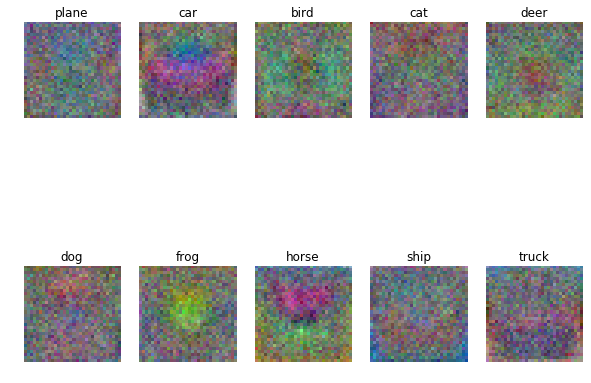

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])